# Mounting the Drive

In [119]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing important Libraries

In [120]:
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
from torch.utils.data import DataLoader

# Loading the data and crearing batches

In [135]:
import numpy as np
import h5py
from torch.utils.data import Dataset, DataLoader

class CocoDataset(Dataset):
    def __init__(self, file_path):
        self.h5_file = h5py.File(file_path, 'r')
        self.dataset_length = len(self.h5_file['/'])

    def __getitem__(self, index):
        data = self.h5_file[str(index)]
        image = np.array(data)  # image.shape = (2, 128, 128)
        label = data.attrs.get('label').flatten()  # label.shape = (8,)
        return image, label

    def __len__(self):
        return self.dataset_length

# Example usage with DataLoader
train_path = '/content/drive/MyDrive/Deep Learning Homography/train.h5'
dataset = CocoDataset(train_path)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


# Print the shapes of the first batch of Train Set
train_batch_images, train_batch_labels = next(iter(dataloader))
print("First Batch of Train Set:")
print("Images shape:", train_batch_images.shape)
print("Labels shape:", train_batch_labels.shape)
print("Total Length of Train Set:", len(dataloader))

First Batch of Train Set:
Images shape: torch.Size([64, 2, 128, 128])
Labels shape: torch.Size([64, 8])
Total Length of Train Set: 1849


# Designing Model's Architecture

In [136]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()

        # Define the layers of the model
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1),  # Convolutional layer with 2 input channels, 64 output channels, and 3x3 kernel
            nn.BatchNorm2d(64, eps= 5e-3),  # Batch normalization to normalize the output of the previous layer
            nn.LeakyReLU(negative_slope=0.2)  # ReLU activation function to introduce non-linearity
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),  # Convolutional layer with 64 input channels, 64 output channels, and 3x3 kernel
            nn.BatchNorm2d(64, eps= 5e-3),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2)  # Max pooling layer with a kernel size of 2x2 to downsample the input
        )
        
        # Repeat the pattern for layer 3 to 8
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64, eps= 5e-3),
            nn.LeakyReLU(negative_slope=0.2)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64, eps= 5e-3),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128, eps= 5e-3),
            nn.LeakyReLU(negative_slope=0.2)
        )
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128, eps= 5e-3),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2)
        )
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128, eps= 5e-3),
            nn.LeakyReLU(negative_slope=0.2)
        )
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128, eps= 5e-3),
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Fully connected layer with 128x16x16 input features and 1024 output features
        self.fc1 = nn.Linear(128 * 16 * 16, 1024)  
        
        
        # Fully connected layer with 1024 input features and 8 output features
        self.fc2 = nn.Linear(1024, 8)  



    def forward(self, x):
        out = self.layer1(x)  # Pass the input through layer 1
        out = self.layer2(out)  # Pass the output of layer 1 through layer 2
        out = self.layer3(out)  # Repeat the process for layers 3 to 8
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = out.view(-1, 128 * 16 * 16)  # Reshape the output tensor to a 1D tensor
        out = self.fc1(out)  # Pass the reshaped tensor through the first fully connected layer
        out = self.fc2(out)  # Pass the output of the first fully connected layer through the second fully connected layer
        return out




# Creating Model Instance and choosing optimizer and Loss

In [138]:
# Define the loss criterion
criterion = nn.SmoothL1Loss()

# Set the number of epochs
epochs = 10

# Create an instance of the model and move it to the appropriate device
model = Model().to(device)

# Define Optimizer
optimizer = optim.Adam(model.parameters())

# Print the model summary
summary(model, input_size=(2, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,216
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
         LeakyReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
       BatchNorm2d-9           [-1, 64, 64, 64]             128
        LeakyReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
      BatchNorm2d-12           [-1, 64, 64, 64]             128
        LeakyReLU-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

# Training the model and calculation Loss

In [140]:
from tqdm import tqdm

optimizer = optim.Adam(model.parameters())

# Training loop for each epoch
for epoch in range(epochs):

    progress_bar = tqdm(total=len(dataloader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch')

    # Iterate over the training dataloader
    for i, (images, target) in enumerate(dataloader):

        images = images.to(device)
        target = target.to(device)

        # Convert images and target to float type
        images = images.float()
        # print(images.shape)
        target = target.float()
        
        # Pass the images through the model
        outputs = model(images)
        
        # Check if any output value is NaN
        if torch.any(torch.isnan(outputs)):
            print(f"Values become NaN in Epoch Number: {epoch} and Batch number: {i} ")
            print(outputs)
            break
        
        # Zero the gradients of the optimizer
        optimizer.zero_grad()
        

        # Calculate the loss between the outputs and target
        loss = criterion(outputs, target.view(-1, 8))

        
        # Perform backpropagation to compute gradients
        loss.backward()

        # Update the model parameters using the gradients
        optimizer.step()

        # Update the progress bar
        progress_bar.set_postfix({'Loss': loss.item()})
        progress_bar.update()
        
    # Print the progress and loss at regular intervals
    # Close the progress bar after completing one epoch
    progress_bar.close()
    

# Save the model's state, epoch, and optimizer parameters
state = {'epoch': epochs, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(state, 'DeepHomographyEstimation.pth')


Epoch 10/10: 100%|██████████| 1849/1849 [08:10<00:00,  3.77batch/s, Loss=4.91]


# Plotting the Loss

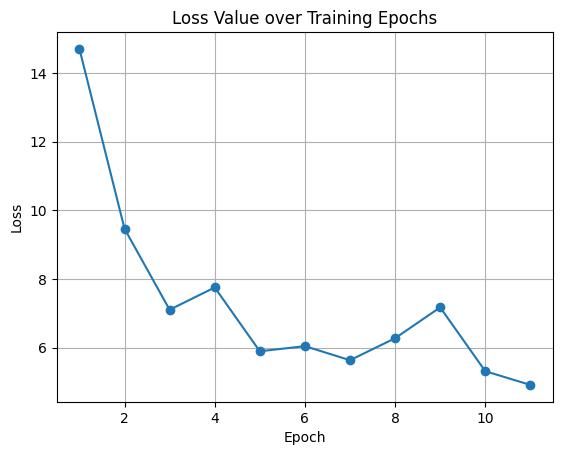

In [142]:
import matplotlib.pyplot as plt

loss_values = [14.7, 9.46, 7.1, 7.75, 5.89, 6.04, 5.63, 6.27, 7.17, 5.31, 4.91]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, marker='o')
plt.title('Loss Value over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


# Testing the model

In [141]:
from numpy.lib.function_base import average
import torch

# Example usage with DataLoader
test_path = '/content/drive/MyDrive/Deep Learning Homography/test.h5'
dataset = CocoDataset(test_path)
test_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Print the shapes of the first batch of Test Set
test_batch_images, test_batch_labels = next(iter(test_dataloader))
print("First Batch of Test Set:")
print("Images shape:", test_batch_images.shape)
print("Labels shape:", test_batch_labels.shape)
print("Total Length of Test Set:", len(test_dataloader))

# Set the model to evaluation mode
model.eval()

Test_Loss = []
with torch.no_grad():
    for i, (images, target) in enumerate(test_dataloader):
        images = images.to(device)
        target = target.to(device)
        images = images.float()
        target = target.float()
        outputs = model(images)
        
        # Custom loss function calculation
        y_pred = outputs
        y = target
        
        diff = y.subtract(y_pred)  # (B, 8) error per corner dimension
        diff = diff.pow(2)  # (B, 8) squared error per corner dimension
        diff = diff.reshape((-1, 4, 2))  # (B, 4, 2) squared error by corner
        diff = diff.sum(-1)  # (B, 4) sum the squared error per corner
        diff = diff.sqrt()  # (B, 4) L2 distance per corner
        diff = diff.mean(-1)  # (B,) mean of L2 distance per sample
        mace = diff.mean(-1)  # (1,) mean over all of the test dataset
        
        Test_Loss.append(mace)
    
    # Print the average loss of the Test Set
    print('\nLoss: {:.6f}'.format(sum(Test_Loss) / len(Test_Loss)))


First Batch of Test Set:
Images shape: torch.Size([64, 2, 128, 128])
Labels shape: torch.Size([64, 8])
Total Length of Test Set: 79

Loss: 8.281489
